In [1]:
from functools import reduce
from pyquaternion import Quaternion 

from pylab import *
import pandas as pd

np.random.seed=1
%matplotlib inline

import pixiedust

import warnings
warnings.filterwarnings("ignore")

Pixiedust database opened successfully


## Helper functions

In [2]:
def toEulerianAngle(q):
    ysqr = q[2] * q[2]

    t0 = +2.0 * (q[0] * q[1] + q[2] * q[3])
    t1 = +1.0 - 2.0 * (q[1] * q[1] + ysqr)
    roll = np.arctan2(t0, t1)

    t2 = +2.0 * (q[0] * q[2] - q[3] * q[1])
    t2 = 1.0 if t2 > 1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = np.arcsin(t2)

    t3 = +2.0 * (q[0] * q[3] + q[1] * q[2])
    t4 = +1.0 - 2.0 * (ysqr + q[3] * q[3])
    yaw = np.arctan2(t3, t4)

    return np.array([roll, pitch, yaw])


def getRollPitchYaw(q):
    return toEulerianAngle(q)


def eulerToQuaternion(roll, pitch, yaw):
    quaternion = [0] * 4
    cosPhi_2 = np.cos(roll / 2)
    sinPhi_2 = np.sin(roll / 2)
    cosTheta_2 = np.cos(pitch / 2)
    sinTheta_2 = np.sin(pitch / 2)
    cosPsi_2 = np.cos(yaw / 2)
    sinPsi_2 = np.sin(yaw / 2)

    quaternion[0] = (cosPhi_2 * cosTheta_2 * cosPsi_2 +
                     sinPhi_2 * sinTheta_2 * sinPsi_2)
    quaternion[1] = (sinPhi_2 * cosTheta_2 * cosPsi_2 -
                     cosPhi_2 * sinTheta_2 * sinPsi_2)
    quaternion[2] = (cosPhi_2 * sinTheta_2 * cosPsi_2 +
                     sinPhi_2 * cosTheta_2 * sinPsi_2)
    quaternion[3] = (cosPhi_2 * cosTheta_2 * sinPsi_2 -
                     sinPhi_2 * sinTheta_2 * cosPsi_2)

    return Quaternion(quaternion)


def transformToEarthFrame(vector, q):
    q_ = Quaternion(q)
    return q_.inverse.rotate(vector)


def transformToBodyFrame(vector, q):
    q_ = Quaternion(q)
    return q_.rotate(vector)


def getGravityVector(roll, pitch):
    x = np.cos(pitch) * np.sin(roll)
    y = -np.sin(pitch)
    z = -np.cos(pitch) * np.cos(roll)
    
    return np.array([x, y, z])
    
def wrapAroundPi(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))


def integrateOrientation(euler, angularVelocity, f):
    return np.array(list(map(wrapAroundPi, euler + angularVelocity / f)))


def integratePosition(p0, v, f):
    return p0 + v / f


def integrateAngularVelocity(w, alpha, f):
    return np.array(list(map(wrapAroundPi, w + alpha / f)))


def integrateLinearVelocity(v, a, f):
    return v + a/f


def downSample(originalFrequency, sampleFrequency, df):
    g = df.groupby(df.index // int(originalFrequency / sampleFrequency))

    d = (g[[i for i in df.columns if i.startswith('d')]].sum() / originalFrequency) * sampleFrequency
    p = g[[i for i in df.columns if i.startswith('d') is False 
           and i not in {'t', 'f', 's', 'aIndex', 'aName'}]].last()
    
    a = g['aIndex'].agg(lambda x: x.value_counts().index[0])

    downSampled = reduce(lambda df1, df2: pd.merge(df1, df2, right_index=True, 
                                                   left_index=True), [p, d, a.to_frame()])
    downSampled['f'] = sampleFrequency
    return downSampled

In [3]:
def getAverageAngularVelocity(p1, p0, f):
    return np.array(list(map(wrapAroundPi, p1 - p0))) * f


def getAverageLinearVelocity(p1, p0, f):
    return np.array((p1 - p0) * f)


def getAverageLinearAcceleration(v1, v0, f):
    return np.array((v1 - v0) * f)


def getAverageAngularAcceleration(v1, v0, f):
    return np.array((v1 - v0) * f)
    
    
def getAveragesBody(df, limit, frequency=10):
    shape = (limit, 3)
    linearVelocities, linearAccelerations = np.zeros(shape), np.zeros(shape)
    angularVelocities, angularAccelerations = np.zeros(shape), np.zeros(shape)

    linearVelocities[1] = getAverageLinearVelocity(df.loc[1, ['x', 'y', 'z']].values,
                                                   df.loc[0, ['x', 'y', 'z']].values,
                                                   frequency)

    angularVelocities[1] = getAverageAngularVelocity(df.loc[1, ['psi', 'theta', 'phi']].values,
                                                     df.loc[0, ['psi', 'theta', 'phi']].values,
                                                     frequency)
    for i in range(2, limit):
        linearVelocities[i] = getAverageLinearVelocity(df.loc[i, ['x', 'y', 'z']].values,
                                                       df.loc[i - 1, ['x', 'y', 'z']].values,
                                                       frequency)

        angularVelocities[i] = getAverageAngularVelocity(df.loc[i, ['psi', 'theta', 'phi']].values,
                                                         df.loc[i - 1, ['psi', 'theta', 'phi']].values,
                                                         frequency)

        linearAccelerations[i] =\
        getAverageLinearAcceleration(linearVelocities[i], linearVelocities[i - 1], frequency)
        
        angularAccelerations[i] =\
        getAverageAngularAcceleration(angularVelocities[i], angularVelocities[i - 1], frequency)
        
    for i, j in zip(range(1, limit), range(2, limit)):
        linearVelocities[i] =\
        transformToBodyFrame(linearVelocities[i], df.loc[i, ['scalar', 'i', 'j', 'k']].values)
        
        linearAccelerations[j] =\
        transformToBodyFrame(linearAccelerations[j], df.loc[i, ['scalar', 'i', 'j', 'k']].values)
        
    return linearVelocities[1:], angularVelocities[1:], linearAccelerations[2:], angularAccelerations[2:]

In [4]:
def getInputOutput(df, frequency, limit=500):
    v, w, a, alpha = getAveragesBody(df, limit, frequency=frequency)
    X, y = np.zeros((limit, 12)), np.zeros((limit, 6))
    
    keymap = {8:'moveForward', 4:'yawCCW', 6:'yawCW', 5:'hover'}
    inverseKeymap = {'moveForward': 0, 'yawCCW': 0, 'yawCW': 0, 'hover': 0}
    
    for i in range(limit-2):
        rowi, action = df.iloc[i+1], df.loc[i+2, 'aIndex']
        inverseKeymap[keymap[action]] = 1
        X[i] = np.concatenate((v[i], w[i], [rowi['psi']], [rowi['theta']], [v for k, v in inverseKeymap.items()]))
        y[i] = np.concatenate((a[i], alpha[i]))
        
    xColumns = ['dXB', 'dYB', 'dZB', 'dPsi', 'dTheta', 'dPhi', 'Psi', 'Theta'] + [i for i in inverseKeymap.keys()]
    yColumns = ['d2XB', 'd2YB', 'd2ZB', 'd2Psi', 'd2Theta', 'd2Phi']
    X, y = pd.DataFrame(X, columns=xColumns),\
           pd.DataFrame(y, columns=yColumns)
    
    return X, y

In [5]:
def integrateTrajectoryVelocityBody(initialPosition, initialOrientation, 
                                    linearVelocitiesBody, angularVelocities, frequency):
    
    for v, w, f in zip(linearVelocitiesBody, angularVelocities, frequency):
        initialOrientation = integrateOrientation(initialOrientation, w, f)
        initialPosition = integratePosition(initialPosition,
                                            transformToEarthFrame(v, eulerToQuaternion(*initialOrientation)), f)
        yield initialPosition

def integrateTrajectoryAccelerationBody(initialPosition, initialOrientation, 
                                        initialLinearVelocityBody, initialAngularVelocity,
                                        linearAccelerationsBody, angularAccelerations, frequency):
    
    for a, alpha, f in zip(linearAccelerationsBody, angularAccelerations, frequency):
        initialAngularVelocity = integrateAngularVelocity(initialAngularVelocity, alpha, f)
        nextOrientation = integrateOrientation(initialOrientation, initialAngularVelocity, f)
        
        initialLinearVelocityBody = integrateLinearVelocity(initialLinearVelocityBody, a, f)
        deltaQuaternion = eulerToQuaternion(*nextOrientation) * eulerToQuaternion(*initialOrientation).inverse
        initialLinearVelocityBody = deltaQuaternion.rotate(initialLinearVelocityBody)
        
        initialPosition = integratePosition(initialPosition, 
                                            transformToEarthFrame(initialLinearVelocityBody, 
                                                                  eulerToQuaternion(*nextOrientation)), f)

        initialOrientation = nextOrientation
        
        yield initialPosition

In [6]:
path1 = 'C:/Users/talaa/PycharmProjects/rl/src/2017_10_26_00_55_52.csv'
dataset = pd.read_csv(path1)
length, width = dataset.shape

## data is collected at 10 Hz

In [7]:
X, y = getInputOutput(dataset, limit=length, frequency=10.0)

In [8]:
X.head()

,dXB,dYB,dZB,dPsi,dTheta,dPhi,Psi,Theta,moveForward,yawCCW,yawCW,hover
0,-2.191665e-08,-3.201676e-10,-0.259528,1.684550e-15,-4.536479e-08,2.357865e-08,2.576613e-14,-2.969615e-09,0.0,0.0,0.0,1.0
1,-1.073255e-08,-3.201887e-10,-0.944887,1.676097e-15,-4.536476e-08,2.366960e-08,2.593374e-14,-7.506091e-09,0.0,0.0,0.0,1.0
2,1.417792e-08,-3.202574e-10,-1.620734,1.644797e-15,-4.536474e-08,2.667548e-08,2.609822e-14,-1.204257e-08,0.0,0.0,0.0,1.0
3,5.180084e-08,-3.203707e-10,-2.268294,1.586770e-15,-4.403049e-08,2.628667e-08,2.625690e-14,-1.644561e-08,0.0,0.0,0.0,1.0
4,8.912986e-08,-3.111778e-10,-2.785208,1.549096e-15,-1.334110e-08,3.137529e-08,2.641181e-14,-1.777972e-08,0.0,0.0,0.0,1.0


In [9]:
y.head()

,d2XB,d2YB,d2ZB,d2Psi,d2Theta,d2Phi
0,6.897639e-08,-6.328217e-14,-6.853592,-8.452550e-17,3.663740e-13,9.094960e-10
1,1.755805e-07,-4.349121e-13,-6.758463,-3.130041e-16,1.332310e-13,3.005880e-08
2,2.763550e-07,-7.906610e-13,-6.475604,-5.802622e-16,1.334248e-08,-3.888090e-09
3,3.361326e-07,9.205046e-11,-5.169141,-3.767409e-16,3.068940e-07,5.088623e-08
4,3.394824e-07,-9.559833e-11,-6.421161,6.282900e-16,3.309109e-06,-1.068656e-08


## Sanity Check

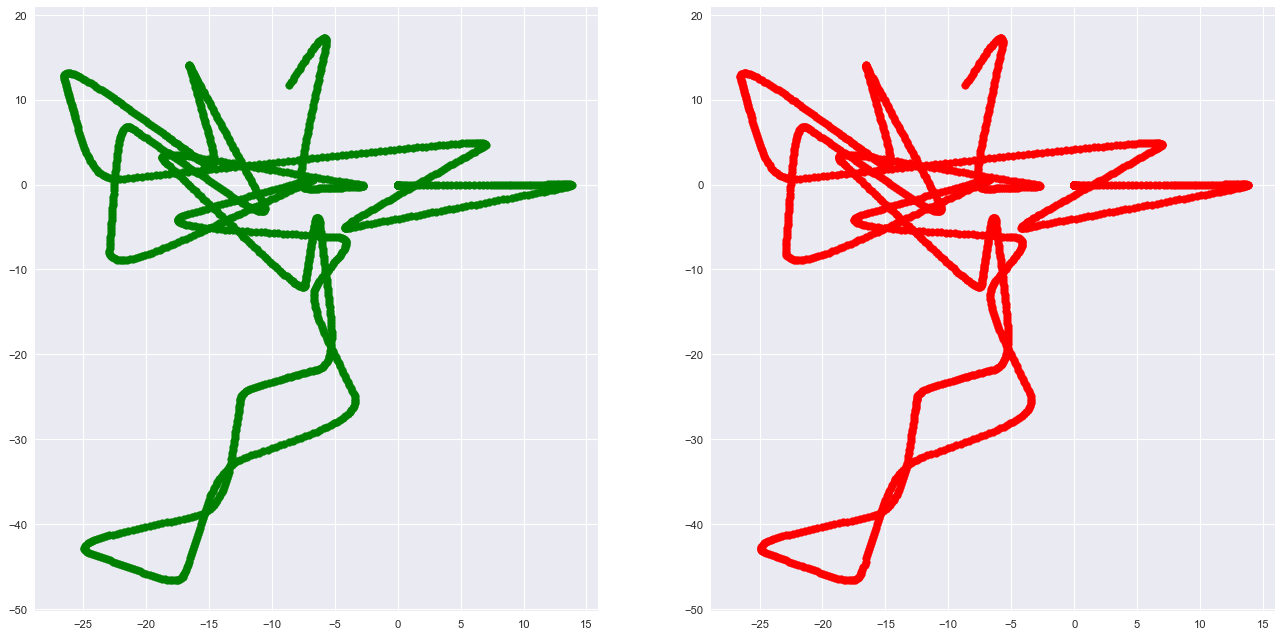

In [10]:
limit = 1500
gen2 = integrateTrajectoryAccelerationBody(initialPosition=dataset.loc[1, ['x', 'y', 'z']].values,
                                           initialOrientation=dataset.loc[1, ['psi', 'theta', 'phi']].values,
                                           initialLinearVelocityBody=X.loc[0, ['dXB', 'dYB', 'dZB']].values,
                                           initialAngularVelocity=X.loc[0, ['dPhi', 'Psi', 'Theta']].values,
                                           
                                           linearAccelerationsBody=y[['d2XB', 'd2YB', 'd2ZB']].values,
                                           angularAccelerations=y[['d2Psi', 'd2Theta', 'd2Phi']].values,
                                           frequency=[10.0] * limit)

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
for i in range(2, limit):
    p = next(gen2)
    subplot(1, 2, 1)
    plt.scatter(dataset.loc[i, ['x']].values, dataset.loc[i, ['y']].values, color='green')
    subplot(1, 2, 2)
    plt.scatter(p[0], p[1], color='red')

In [11]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest =\
train_test_split(X, y, test_size=0.20, random_state=1)

### MLP Regressor

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(5, ), (10, ), (15, ), (25, )], 'alpha':[1e-4 * np.exp(i) for i in range(10)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['d2Theta'], yTest['d2Theta']) ** 0.5

5.8509237694692793

In [13]:
model = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                     alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5, random_state=10).fit(xTrain, yTrain)

In [42]:
yPredicted = pd.DataFrame(model.predict(xTest), columns=y.columns)
mean_squared_error(yPredicted['d2Theta'], yTest['d2Theta']) ** 0.5

5.7540293658384627

In [16]:
def d2Psi(x, cpsi, c1, d1):
    # Cφ * dPsi + C1 * (moveForward + -hover) + D1
    pass

def d2Theta(x, ctheta, c2, d2):
    # Ċθ * dTheta + C2 * (moveForward + -hover) + D2
    return ctheta * x['dPhi'] + c2 * (-x['moveForward'] + x['hover']) + d2

def d2Phi(x, cphi, c3, d3):
    # Cω * dPhi + C3 * (-yawCw + yawCCw) + D3
    return cphi * x['dPhi'] + c3 * (-x['yawCw'] + x['yawCCw']) + d3

def d2XB(x):
    # Cx * dXB + gx
    pass

def d2YB(x):
    # Cy * dYB + gy + D0
    pass

def d2ZB(x):
    # Cz * dZB + gz + C4 * u4 + D4
    pass